In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Loading and Subsetting ---
mnist_mean = (0.1307,)
mnist_std = (0.3081,)

train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
full_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transform)



# Use only 50,000 for training and 10000 for testing
train_dataset = Subset(full_train_dataset, range(50000))
test_dataset = Subset(full_test_dataset, range(10000))
print(f"Training Dataset: {len(train_dataset)}")
print(f"Testing Dataset: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Batch Size: {batch_size}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Training Dataset: 50000
Testing Dataset: 10000
Batch Size: 32
Using device: cuda


In [81]:
import torch.nn as nn

class DS_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: Feature Extraction
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=0) # Output 26x26x8
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=0) # Output 24x24x16
        self.bn2 = nn.BatchNorm2d(16)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output 12x12x16
        self.dropout1 = nn.Dropout(0.1)

        # Block 2: Further Feature Extraction
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, padding=0) # Output 10x10x24
        self.bn3 = nn.BatchNorm2d(24)
        
        self.conv4 = nn.Conv2d(24, 24, kernel_size=3, padding=0) # Output 8x8x24
        self.bn4 = nn.BatchNorm2d(24)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output 4x4x24
        self.dropout2 = nn.Dropout(0.2)

        # Block 3: Classification Head
        self.conv5 = nn.Conv2d(24, 32, kernel_size=3, padding=0) # Output 2x2x32
        self.bn5 = nn.BatchNorm2d(32)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Output 32 features
        
        self.fc = nn.Linear(in_features=32, out_features=10) # Output 10 classes

    def forward(self, x):
        # Block 1
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.ReLU()(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = nn.ReLU()(self.bn5(self.conv5(x)))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1) # Flatten for the fully connected layer
        x = self.fc(x)
        return x


In [82]:
# Instantiate and check parameter count
model = DS_CNN().to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 17418


In [83]:
# --- 3. Training and Evaluation Functions ---
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy


In [84]:
# --- 4. Training Loop ---
epochs = 19
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=0,factor=0.5)

train_accuracies = []
test_accuracies = []
train_count = len(train_loader.dataset)
test_count = len(test_loader.dataset)

for epoch in range(epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    scheduler.step(test_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}: "
          f"Train Acc: {train_acc:.2f}% (Train set: {train_count}), "
          f"Test Acc: {test_acc:.2f}% (Test set: {test_count})")

Epoch 1: Train Acc: 92.50% (Train set: 50000), Test Acc: 98.51% (Test set: 10000)
Epoch 2: Train Acc: 95.91% (Train set: 50000), Test Acc: 98.86% (Test set: 10000)
Epoch 3: Train Acc: 96.38% (Train set: 50000), Test Acc: 98.53% (Test set: 10000)
Epoch 4: Train Acc: 97.46% (Train set: 50000), Test Acc: 99.15% (Test set: 10000)
Epoch 5: Train Acc: 97.59% (Train set: 50000), Test Acc: 99.17% (Test set: 10000)
Epoch 6: Train Acc: 97.77% (Train set: 50000), Test Acc: 99.22% (Test set: 10000)
Epoch 7: Train Acc: 97.71% (Train set: 50000), Test Acc: 99.05% (Test set: 10000)
Epoch 8: Train Acc: 98.14% (Train set: 50000), Test Acc: 99.40% (Test set: 10000)
Epoch 9: Train Acc: 98.23% (Train set: 50000), Test Acc: 99.43% (Test set: 10000)
Epoch 10: Train Acc: 98.36% (Train set: 50000), Test Acc: 99.49% (Test set: 10000)
Epoch 11: Train Acc: 98.27% (Train set: 50000), Test Acc: 99.32% (Test set: 10000)
Epoch 12: Train Acc: 98.50% (Train set: 50000), Test Acc: 99.56% (Test set: 10000)
Epoch 13: Tra

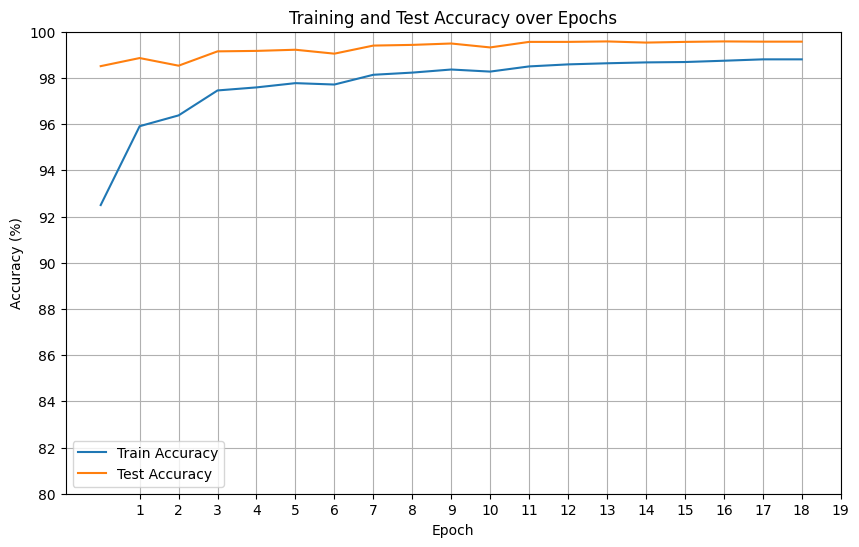

In [90]:
# --- 5. Plotting (optional) ---
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.xticks(range(1, epochs + 1))
plt.yticks([i for i in range(80, 101, 2)])
plt.legend()
plt.grid(True)
plt.show()